## How do linear regression and decision trees respond to outliers?

It's a piece of data science 'folk wisdom' that decision trees handle outliers more naturally than linear regression, because the predictions at each node are averaged among the observations. Are there cases where this is not true? Let's investigate.

In [119]:
import numpy as np

In [120]:
from scipy.stats import norm

Alright let's generate some sample data. It will vary along y=2x.

In [18]:
x = norm.rvs(size=25).reshape(-1,1)
y = [2*xi + norm.rvs() for xi in x]

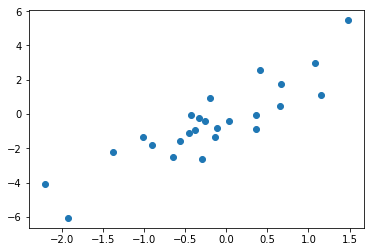

In [19]:
plt.scatter(x,y)
plt.show()

Now we can look at the linear regression of these data, including the sum of squared errors:

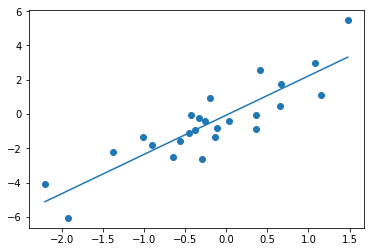

The total squared error is 29.33
The R-squared value is: 0.77


In [79]:

from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(x,y)

def plot_linreg(argx,argy,arg_linreg):
    minx = min(argx);maxx = max(argx)
    predminy=arg_linreg.intercept_[0]+minx*arg_linreg.coef_[0][0]
    predmaxy=arg_linreg.intercept_[0]+maxx*arg_linreg.coef_[0][0]
    plt.scatter(argx,argy)
    plt.plot((minx,maxx),(predminy,predmaxy))
    plt.show()

def get_sse(x,y,linreg):
    b = linreg.intercept_[0];m=linreg.coef_[0][0]
    ret = sum( (yi-(b+m*xi))**2 for xi,yi in zip(x,y) )
    return ret
    
plot_linreg(x,y,linreg)
print('The total squared error is {:.2f}'.format( linreg._residues[0]))
print('The R-squared value is: {:.2f}'.format(linreg.score(x,y)))


Now, let's add an outlier point and see how the linear regression is affected.

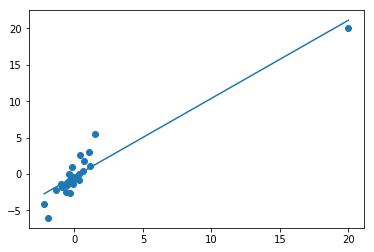

The total squared error is 58.51
The R-squared value is: 0.89
The total squared error without outlier is 57.23


In [121]:
far_x = np.append(x,20).reshape(-1, 1)
far_y = np.append(y,20).reshape(-1, 1)

far_linreg = LinearRegression()
far_linreg.fit(far_x,far_y)

plot_linreg(far_x,far_y,far_linreg)
print('The total squared error is {:.2f}'.format( far_linreg._residues[0]))
print('The R-squared value is: {:.2f}'.format(far_linreg.score(far_x,far_y)))
print('The total squared error without outlier is {:.2f}'.format( 
    get_sse(far_x[:-1,:], far_y[:-1,:], far_linreg )[0] ) )

The outlier point was added at (x,y) = (20,20), which is along the line y=1*x, unlike the data sampled so far which was along y = 2*x. This means the same line will not fit both the outlier and the sampled data well. Indeed, the error increases from about 29 to about 58, or 57 without the outlier. So, roughly speaking, sum of squared error doubles.

## R^2 increases. How?

Interestingly, the R^2 value increases significantly, even though the fit is arguably much worse. We can explain this apparent paradox with reference to the definition of R^2. It is the fraction of total variance explained by the best fit line. The variance contributed by each point varies as the square of the distance to the mean. The mean is close to the large cluster, meaning that the outlier point contributes a big chunk of the variance. The line captures most of the variance of the outlier. In short, the total variance and the explained variance increase greatly, while the unexplained variance increases only slightly. Overall, this illustrates a weakness of R^2 if it's used as a measure of fit for linear regressions.

## Another kind of outlier

Let's now try an outlier in the middle of the independent variable's range, rather than at an extreme.

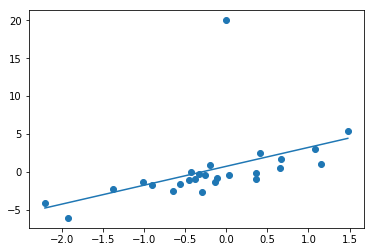

The total squared error is 415.79
The R-squared value is: 0.22
The total squared error without outlier is 44.95


In [83]:
middle_x = np.append(x,0).reshape(-1, 1)
middle_y = np.append(y,20).reshape(-1, 1)

middle_linreg = LinearRegression()
middle_linreg.fit(middle_x,middle_y)

plot_linreg(middle_x,middle_y,middle_linreg)
print('The total squared error is {:.2f}'.format( middle_linreg._residues[0]))
print('The R-squared value is: {:.2f}'.format(middle_linreg.score(middle_x,middle_y)))
print('The total squared error without outlier is {:.2f}'.format( 
    get_sse(middle_x[:-1,:], middle_y[:-1,:], middle_linreg )[0] ) )

The best fit line here actually changes very little in response to the outlier. It is dragged up slightly, enough to make error increase by about 50%, not counting the outlier. However, the line will still fit points generated by the original statistical process fairly well.

## Comparison with decision trees

Let's now compare how decision trees handle these outliers.

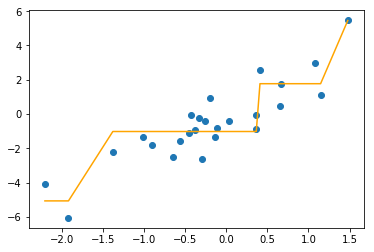

The total squared error is 20.62


In [126]:
from sklearn.tree import DecisionTreeRegressor

def plot_dtree(argx,argy,argtree):
    predy = argtree.predict(argx)
    plt.scatter(argx,argy)
    sort_ind=np.argsort( argx.reshape(-1)  )
    plt.plot(argx.reshape(-1)[sort_ind] ,predy.reshape(-1)[sort_ind], color='orange' )
    plt.show()
    
def get_dtree_sse(argx,argy,argtree):
    predy = argtree.predict(argx)
    sse = sum( ( argyi[0] - predyi )**2 for argyi,predyi in zip( argy , predy ) )
    return sse
    
dtree = DecisionTreeRegressor(max_depth=2)
dtree.fit(x,y)
plot_dtree(x,y,dtree)

print('The total squared error is {:.2f}'.format( get_dtree_sse( x,y,dtree ) ) )


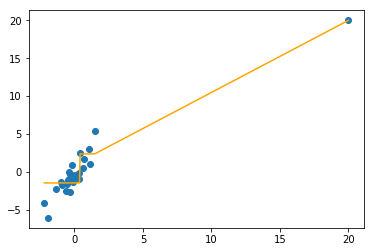

The total squared error is 61.29


In [127]:
    
far_dtree = DecisionTreeRegressor(max_depth=2)
far_dtree.fit(far_x,far_y)
plot_dtree(far_x,far_y,far_dtree)

print('The total squared error is {:.2f}'.format( get_dtree_sse( far_x,far_y,far_dtree ) ) )

We see the error roughly triple, before and after. Here we are interested in how the fit changes in response to the addition of the outlier. And we can see that overall, the decision tree's error is now worse than the linear regression, where it used to be better.

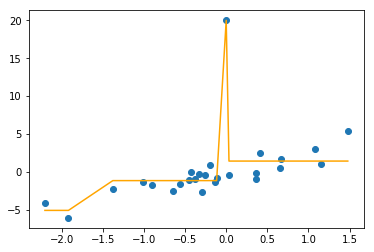

The total squared error is 61.29


In [128]:

middle_dtree = DecisionTreeRegressor(max_depth=2)
middle_dtree.fit(middle_x,middle_y)
plot_dtree(middle_x,middle_y,middle_dtree)

print('The total squared error is {:.2f}'.format( get_dtree_sse( far_x,far_y,far_dtree ) ) )


Again, the error roughly triples.

## What's going on here

In both cases, the outlier becomes its own leaf on the decision tree. It's worth remembering that decision tree branches are often created on the basis of minimizing squared error. Thus, any significant outlier is sure to be among the first branches created. The existence of the outlier reduces the effective number of leaves by one. This process tends to argue against decision trees as necessarily more effective at handling outliers due to the averaging of leaves, as outliers tend to get their own leaves.

Importantly, points submitted to the model for prediction that are sufficiently close to the outlier will be estimated at the value of the outlier, which was not always the case for linear regression. 

This discussion does not exhaust the dynamics of outliers in linear regression and decision trees. You may repeat this experiment with additional depth on the decision tree. The effect of the outlier on error will be reduced, but in this example, the tree quickly overfits. A full analysis would require measuring error against points not yet seen by the model. This merely serves to start the discussion.